<a href="https://colab.research.google.com/github/LeeYuuuan/DataMiningProject/blob/main/runnnnnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# add dependencies

In [3]:
%pip install grakel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 9.3 MB/s 
     |████████████████████████████████| 154 kB 45.0 MB/s 


In [4]:
import grakel
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import networkx.algorithms.isomorphism as iso
import time

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Draw Graph

In [1]:
def draw_graphs(G,G1):
    pos = nx.spring_layout(G)
    pos1 = nx.spring_layout(G1) 
    plt.subplot(121)
    nx.draw(G, pos, with_labels=True, node_color='pink', node_size=500)
    plt.subplot(122)
    nx.draw(G1, pos1, with_labels=True, node_size=500)
    plt.show()



#Load Data

In [6]:
def GetGraphData(dataset_name):
  dataset = grakel.datasets.fetch_dataset(dataset_name, verbose=True, data_home=None, download_if_missing=True, with_classes=True, produce_labels_nodes=False, prefer_attr_nodes=False, prefer_attr_edges=False, as_graphs=False)
  G = dataset.data
  y = dataset.target
  return G, y

Extracting dataset  SYNTHETIC..
Parsing dataset  SYNTHETIC..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..


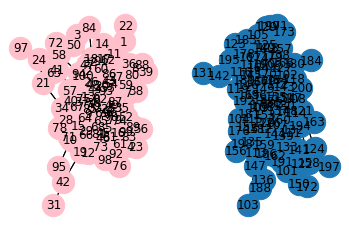

In [ ]:
G[0]

#graph isomorphism

In [8]:
def GetGraph(an_old_graph):
  """
  This function input a graph from /grakel dataset/
  Then converted to a type [class]Graph (networkx)
  """
  Graph = nx.MultiGraph()
  Graph.add_edges_from(list(an_old_graph[0]))

  if len(an_old_graph[1]) != 0:
    for node in an_old_graph[1]:
      Graph.add_node(node, attr=an_old_graph[1][node])
  if len(an_old_graph[2]) !=0:
    for edge in an_old_graph[2]:
      Graph.add_edge(edge[0],edge[1], attr=an_old_graph[2][edge])
  
  return Graph

In [9]:
def GetAllGraph(graph_dataset):
  """
  Get all Graph with type of [class]Graph
  return a list [Graph1, Graph2, ...]
  """
  Graphs = []
  for graph_data in graph_dataset:
    Graphs.append(GetGraph(graph_data))
    
  return Graphs

# WL-test

In [ ]:
draw_graphs(Graphs[0],Graphs[2])

In [9]:
Graphs = GetAllGraph(G)

In [8]:
def multiset_define(Graph): #复合集的生成与排序拼接,复合集value为邻居节点排序后标签
    """
    G is a nx.Graph

    return a dict: {node_id: list[current_node_label, nb1_node_label,nb2_node_balel, ...], node_id2: ...}
    
    
    """
    multiset = {}
    multiset1 = {}
    label = nx.get_node_attributes(Graph,'attr') # label: {node_id: attr}
    for node in Graph.nodes():
        all_node_list = []
        neighboors = nx.all_neighbors(Graph, node)
        node_list = []
        #print("ith iter")
        node_list.append(Graph.nodes[node]["attr"])
        #node_list.append(label[node])
        node_list_others = []
        for node_of_neighboor in neighboors:
            node_list_others.append(label[node_of_neighboor])
        node_list_others.sort()
        
        #node_list.append(node_list_others) #这种写法可以将 Node attr 与 邻居的attr 分开： [current_attr, [oth1,oth2,...]]

        for e in node_list_others:
            node_list.append(e)

        list_new = [x for x in node_list]
        multiset[node] = list_new
        #multiset1[node] = "".join(list_new)

    return  multiset

In [ ]:
multiset_define(Graphs[6])

In [10]:
def get_graphs_multiset_list(graphs_list):
  """
  get multiset list from  list: class --> graphs.
  return graphs multiset list.
  """

  graphs_multiset_list = [] # get the list of all multisets for every nodes. list:[{node_id: nieghboor_label_list[label1, label2,...]...}...]

  for graph in graphs_list:
      graphs_multiset_list.append(multiset_define(graph))
    
  return graphs_multiset_list
    

In [11]:
graphs_multiset_list = get_graphs_multiset_list(Graphs)
#graphs_multiset_list[0] # e.g. a element of this list : dict{node:[label_list],...}

In [ ]:
graphs_multiset_list[0]

In [ ]:
#for test
x1, y1 = get_map_from_label_list_to_sorted_id([graphs_multiset_list[0]])
x2, y2 = get_map_from_label_list_to_sorted_id([graphs_multiset_list[2]])


In [ ]:
x1

In [ ]:
abel_list, label_mapping_to_new, label_mapping_to_old, graphs_multiset_list = remap_the_label(graphs_multiset_list)

In [ ]:
x2

In [ ]:
"""
Init multi label set:
{Node_id: Node:label, ...}
"""
nx.get_node_attributes(Graphs[0], 'attr')


In [ ]:
#no use
G1 = nx.MultiGraph()   #有多重边无向图
G1.add_node(1,label='1')  #添加节点
G1.add_node(2,label='1')
G1.add_node(3,label='1')
G1.add_node(4,label='1')
G1.add_node(5,label='1')
G1.add_node(6,label='1')
edges1 = [(1,5),(2,4),(4,5),(3,5),(3,6),(4,6),(5,6)]
G1.add_edges_from(edges1)

In [18]:
label = nx.get_node_attributes(G1,'label') # label: {node_id: attr}

In [ ]:
label

In [14]:
def remap_the_label(graphs_multiset_list):
  """
  remap the label.
  i.e. label set [1, 4, 5]
  {new_label:origin_label}
  return {1:1, 2:4, 3:5}, relabeled graphs list.
  """
  label_set = set()
  for graph in graphs_multiset_list:
      for node in graph.keys():
          
          for label in graph[node]:
              label_set.add(label)

  label_list = list(label_set)
  label_list.sort()
  label_mapping_to_new = {}
  label_mapping_to_old = {}
  for i in range(len(label_list)):
      old_label = label_list[i]
      label_mapping_to_old[i] = old_label
      label_mapping_to_new[old_label] = i
    
  for graph in graphs_multiset_list:
      for node in graph.keys():
          temp_list = []
          for label in graph[node]:
              temp_list.append(label_mapping_to_new[label])
          graph[node] = temp_list
           
  
  return label_list, label_mapping_to_new, label_mapping_to_old, graphs_multiset_list

  

In [15]:
label_list, label_mapping_to_new, label_mapping_to_old, graphs_multiset_list = remap_the_label(graphs_multiset_list)

In [19]:
label_list

[1, 6, 7, 8, 9, 15, 16, 17, 35, 53]

In [20]:
label_mapping_to_new

{1: 0, 6: 1, 7: 2, 8: 3, 9: 4, 15: 5, 16: 6, 17: 7, 35: 8, 53: 9}

In [21]:
label_mapping_to_old

{0: 1, 1: 6, 2: 7, 3: 8, 4: 9, 5: 15, 6: 16, 7: 17, 8: 35, 9: 53}

In [ ]:
graphs_multiset_list[6]

In [16]:
def calculate_feature_vector_dict(graphs_multiset_list):
  """
  calculate feature vector for current label list.

  calculate sum number of every node with the same label respectively.
  """
  feature_vector_list_dict = []

  for graph in graphs_multiset_list:
      feature_vector = {}
      for node in graph.keys():
          if graph[node][0] in feature_vector.keys():
              feature_vector[graph[node][0]] = feature_vector[graph[node][0]] + 1
          else:
              feature_vector[graph[node][0]] = 1
      feature_vector_list_dict.append(feature_vector)

  return feature_vector_list_dict


In [17]:
feature_vector_list_dict = calculate_feature_vector_dict(graphs_multiset_list)

In [198]:
feature_vector_list_dict[0]

{0: 11, 1: 15, 2: 2, 3: 1, 4: 1}

In [199]:
feature_vector_list_dict[2]

{0: 10, 1: 15, 2: 2, 3: 1, 4: 2}

In [ ]:
feature_vector_list_dict

In [18]:
def calculate_feature_vector(feature_vector_list_dict, len_label_list):
    """
    calculate the feature vector.
    """
    feature_vector_list = []
    
    for graph in feature_vector_list_dict:
        feature_vector = [0] * len_label_list
        for feature in graph:
            feature_vector[feature] = graph[feature]
        
        feature_vector_list.append(feature_vector)
    
    return feature_vector_list


In [197]:
calculate_feature_vector(feature_vector_list_dict, len(label_list))[0]

[11, 15, 2, 1, 1, 0, 0, 0, 0, 0]

In [ ]:
len_label_list = len(label_list)
calculate_feature_vector(feature_vector_list_dict, len_label_list)

In [19]:
def get_map_from_label_list_to_sorted_id(graphs_multiset_list):
    """{node_id: [label, label, ...]
        node_id: [label, lable, ...] ---> {[label,....]: id , []:id,...}
        ...                        }
        relabel

        return list with new label.
    """
    label_list_set = []
    for graph in graphs_multiset_list:
        for node in graph:
            if graph[node] not in label_list_set:
                label_list_set.append(graph[node])
    
    label_list_set.sort()

    for graph in graphs_multiset_list:
        for node in graph:
            graph[node] = label_list_set.index(graph[node])
    
    return label_list_set, graphs_multiset_list


In [21]:
label_list_set, graphs_multiset_list  = get_map_from_label_list_to_sorted_id(graphs_multiset_list)

In [ ]:
graphs_multiset_list[0]

In [22]:
def calculate_next_multiset_once(graph,graph_multiset, label_list_set):
    """
    calculate the multiset after ith iteration.
    """
    multiset = {}
    for node in graph.nodes():
        neighboors = nx.all_neighbors(graph, node)

        node_list = []
            #print("ith iter")
        node_list.append(graph_multiset[node])
        #node_list.append(label[node])
        node_list_others = []
        
        for node_of_neighboor in neighboors:
            node_list_others.append(graph_multiset[node_of_neighboor])
        node_list_others.sort()
        
        for e in node_list_others:
            node_list.append(e)

        list_new = [x for x in node_list]
        multiset[node] = list_new

    return multiset



In [ ]:
calculate_next_multiset_once(Graphs[0], graphs_multiset_list[0], label_list_set)

In [24]:
def get_iteration_graphs_multiset_list(graphs_list, graphs_multiset_list, label_list_set):
    """
    get multiset list after iteration.
    return graphs multiset list.
    """

    graphs_iteration_multiset_list = [] # get the list of all multisets for every nodes. list:[{node_id: nieghboor_label_list[label1, label2,...]...}...]


    for i in range(len(graphs_list)):
        graphs_iteration_multiset_list.append(calculate_next_multiset_once(graphs_list[i], graphs_multiset_list[i], label_list_set))
        
    
    return graphs_iteration_multiset_list
    

In [ ]:
get_iteration_graphs_multiset_list(Graphs, graphs_multiset_list, label_list_set)

In [102]:
len(graphs_multiset_list)

405

In [25]:
def feature_vector_append(feature_vector_all, feature_vector):
    """
    append a feature vector list after a certain iteration.
    """
    if feature_vector_all is None:
        return feature_vector
    
    else:
        for i in range(len(feature_vector)):
            for e in feature_vector:
                feature_vector_all[i].append(e)
        return feature_vector_all


In [86]:
def wl_test_ha(graphs_list):
    n = len(graphs_list)
    graphs_multiset_list = get_graphs_multiset_list(Graphs) # get the list of all multisets for every nodes. list:[{node_id: nieghboor_label_list[label1, label2,...]...}...]


    vector_len_list = []
    feature_vector_all = None

    for iteration in range(1):
        # get label list, label transform list and remapped list.
        label_list, label_mapping_to_new, label_mapping_to_old, graphs_multiset_list = remap_the_label(graphs_multiset_list)

        # get feature vector dict and list.
        feature_vector_list_dict = calculate_feature_vector_dict(graphs_multiset_list)
        len_label_list = len(label_list)
        feature_vector = calculate_feature_vector(feature_vector_list_dict, len_label_list)

        feature_vector_all = feature_vector_append(feature_vector_all, feature_vector)
        vector_len_list = []

        # get new graphs multiset list after relabeling.
        label_list_set, graphs_multiset_list  = get_map_from_label_list_to_sorted_id(graphs_multiset_list)

        graphs_multiset_list = get_iteration_graphs_multiset_list(Graphs, graphs_multiset_list, label_list_set)

    
    return feature_vector_all
    

        

    


    




In [81]:
vector_all = wl_test_ha(Graphs)

In [ ]:
len(vector_all[0)

In [217]:
len(Graphs[1].nodes())

33

In [ ]:
vector_all[0]

In [13]:
def multiset_join(G,dictx):    #把v上一轮的标签作为前缀，添加到s里
    node_label = nx.get_node_attributes(G,'attr')
    for u in dictx.keys():
        dictx[u] = node_label[u] + dictx[u]
    return dictx

In [17]:
node_label = nx.get_node_attributes(G1,'attr')

In [219]:
len(Graphs[404].nodes())

31

In [ ]:
pos = nx.spring_layout(Graphs[0])
plt.subplot(121)
node_labels = nx.get_node_attributes(Graphs[0], 'attr')
"""
for k in node_labels:
  node_labels[k] = int(node_labels[k])
"""

nx.draw(Graphs[0], pos, with_labels=False, node_color='pink', node_size=300)
nx.draw_networkx_labels(Graphs[0], pos, labels = node_labels)

pos1 = nx.spring_layout(Graphs[2])
plt.subplot(122)
node_labels1 = nx.get_node_attributes(Graphs[2], 'attr')
"""
for k in node_labels1:
  node_labels1[k] = int(node_labels1[k])
"""
nx.draw(Graphs[2], pos1, with_labels=False, node_size=300)
nx.draw_networkx_labels(Graphs[2], pos1, labels = node_labels1)
plt.show()

WL_test(node_labels,node_labels1,Graphs[0],Graphs[2])

# wl_test classification

In [71]:
def CreateFeatureMatrix_wl_test(vector_all):
  feature_matrix = np.zeros([len(vector_all),len(vector_all[0])])
  for i in range(len(vector_all)):
      feature_matrix[i,:] = vector_all[i]
      #feature_matrix[i,j] = IsIsomorphicDefault(graphs[i],graphs[j],is_node_labeled,is_edge_labeled)
   
  
  return feature_matrix



In [ ]:
vector_all[0]

In [ ]:
fe_m = CreateFeatureMatrix_wl_test(feature_matrix)

In [77]:
G_train, G_test, y_train, y_test = train_test_split(fe_m, y, test_size=0.1, random_state=42)
clf = SVC(kernel='linear')
clf.fit(G_train, y_train)
SVC(kernel='linear')
y_pred = clf.predict(G_test)

print(str(round(accuracy_score(y_test, y_pred)*100, 2)), "%")

85.37 %


# Isomorphism

In [9]:
def IsIsomorphicDefault(G1,G2,is_node_labeled,is_edge_labeled):
  """
  Input two Graphs G1, G2,
  Input True/False if Node/edge is labeled or not.

  return True/False if two Graphs is isomorphic or not.
  """
  if is_node_labeled:
    nm = iso.numerical_node_match("attr",0)
    if is_edge_labeled:
      em = iso.numerical_edge_match("attr",-1)
      GM = iso.GraphMatcher(G1, G2, node_match=nm, edge_match=em)
    else:
      GM = iso.GraphMatcher(G1, G2, node_match=nm)
  else:
    if is_edge_labeled:
      em = iso.numerical_edge_match("attr",-1)
      GM = iso.GraphMatcher(G1, G2, edge_match=em)
    else:
      GM = iso.GraphMatcher(G1, G2)
  
  return np.float64(GM.is_isomorphic())


In [67]:
flag = []
for i in range(405):
    for j in range(100):
        if IsIsomorphicDefault(Graphs[i],Graphs[j],True,False) == 1:
            flag.append([i,j])

In [ ]:
flag

In [15]:
Graphs = GetAllGraph(G)

In [23]:
t0 = time.time()
List = []
for i in range(300):
    List.append(IsIsomorphicDefault(Graphs[0],Graphs[i],False,False))
    
print("done in %0.3fs\n" % (time.time() - t0))



done in 15.290s



In [28]:

t0 = time.time()
feature_matrix = np.zeros([len(Graphs),len(Graphs)])
for i in range(300):
    for j in range(300):
        if nx.weisfeiler_lehman_graph_hash(Graphs[0]) == nx.weisfeiler_lehman_graph_hash(Graphs[i]):
            feature_matrix[i][j] = 1
    if i % 50 == 0:
        print(i, "th done in %0.3fs\n" % (time.time() - t0))




0 th done in 1.336s

50 th done in 71.369s

100 th done in 139.841s

150 th done in 209.291s

200 th done in 277.223s

250 th done in 346.425s



In [31]:
nx.weisfeiler_lehman_graph_hash(Graphs[0]) == nx.weisfeiler_lehman_graph_hash(Graphs[2])

True

In [32]:
feature_matrix

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

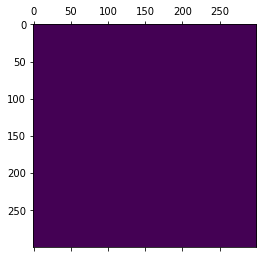

In [29]:
plt.matshow(feature_matrix)

In [ ]:
List

In [19]:
15*300/60

75.0

In [57]:
nm = iso.numerical_node_match("attr",1)
nx.is_isomorphic(Graphs[0], Graphs[2], node_match=nm)

False

In [ ]:
#Test
nx.get_node_attributes(Graphs[0], 'attr')

In [98]:
#test
Graphs[0].add_node(0, attr=7)

In [140]:
IsIsomorphicDefault(Graphs[0],Graphs[2],True, False)

1.0

In [146]:
graph

NodeView((4, 7, 10, 11, 5, 6, 12, 9, 8, 2, 1, 3, 21, 15, 16, 18, 19, 22, 17, 20, 26, 24, 29, 28, 27, 30, 25, 13, 14, 23))

In [64]:
#test for all isomorphic between labeled and unlabeled.
TargetList = []
T1 = []
for i in range(len(Graphs)):
  TargetList.append(IsIsomorphicDefault(Graphs[0],Graphs[i],True, False))
  T1.append(IsIsomorphicDefault(Graphs[0],Graphs[i],False, False))

In [65]:
T1 == TargetList

True

In [ ]:
def CreateFeatureMatrix(graphs,is_node_labeled,is_edge_labeled):
  feature_matrix = np.zeros([len(graphs),len(graphs)])
  for i in range(len(graphs)):
    for j in range(i, len(graphs)):
      feature_matrix[i,j] = IsIsomorphicDefault(graphs[i],graphs[j],is_node_labeled,is_edge_labeled)
   
  
  return feature_matrix



In [ ]:
def GetIsomorphicFeatureMatrix(dataset_name,is_node_labeled,is_edge_labeled):
  G, y = GetGraphData(dataset_name)
  all_graph = GetAllGraph(G)
  return CreateFeatureMatrix(all_graph,is_node_labeled,is_edge_labeled), y
  

In [ ]:
#for test
dataset_name = 'MSRC_21'
f_m, y = GetIsomorphicFeatureMatrix(dataset_name,False,False)


Extracting dataset  MSRC_21..
Parsing dataset  MSRC_21..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..


In [ ]:
f_m

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
isom = []
clm = []
count = 0
import pandas as pd
for i in range(f_m.shape[0]):
  for j in range(i+1,f_m.shape[1]):
   if f_m[i,j] == 1:
    count += 1
   isom.append(f_m[i,j])
   clm.append(not(y[i] ^ y[j]))

A1=pd.Series(isom)
B1=pd.Series(clm)
corr=B1.corr(A1,method='pearson')
print(corr)

0.0011680770374457498


In [ ]:
count

243

In [ ]:
243*2/((344*344)-344)

0.00411892331683504

#graph kernel 

In [ ]:
def GetKernelFeautreMartix(dataset_name,kernel_name):
  pass
  

In [ ]:
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)

In [ ]:
type(G_train)

list

In [ ]:
def Grk(dataset_anme):
  G, y = GetGraphData(dataset_name)
  G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)
  gk = grakel.GraphKernel(kernel=[{"name": "weisfeiler_lehman", "n_iter": 5}, "subtree_wl"] ,Nystroem=20)
  K_train = gk.fit_transform(G_train)
  K_test = gk.transform(G_test)

  clf = SVC(kernel='linear')
  clf.fit(K_train, y_train)
  SVC(kernel='linear')
  y_pred = clf.predict(K_test)
  print(str(round(accuracy_score(y_test, y_pred)*100, 2)), "%")

In [ ]:
Grk("PTC_MR")

Extracting dataset  PTC_MR..
Parsing dataset  PTC_MR..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..
48.57 %


#classification 

In [ ]:
G_train, G_test, y_train, y_test = train_test_split(f_m, y, test_size=0.1, random_state=42)
clf = SVC(kernel='linear')
clf.fit(G_train, y_train)
SVC(kernel='linear')
y_pred = clf.predict(G_test)

In [ ]:

print(str(round(accuracy_score(y_test, y_pred)*100, 2)), "%")

62.86 %


In [ ]:
isom = []
clm = []
count = 0
import pandas as pd
for i in range(f_m.shape[0]):
  for j in range(i,f_m.shape[1]):
    if f_m[i,j] == 1:
      count += 1
    isom.append(f_m[i,j])
    isom.append(y[i] ^ y[j])

A1=pd.Series(isom)
B1=pd.Series(clm)
corr=B1.corr(A1,method="pearson")
print(corr)

nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
f_m.shape[1]

209

# SYNTHETIC analysis

Extracting dataset  SYNTHETIC..
Parsing dataset  SYNTHETIC..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..


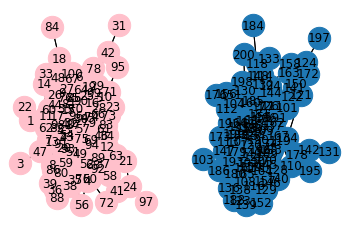

In [25]:
# for test
G,y = GetGraphData("SYNTHETIC")
Gra = GetAllGraph(G)
draw_graphs(Gra[0],Gra[1])

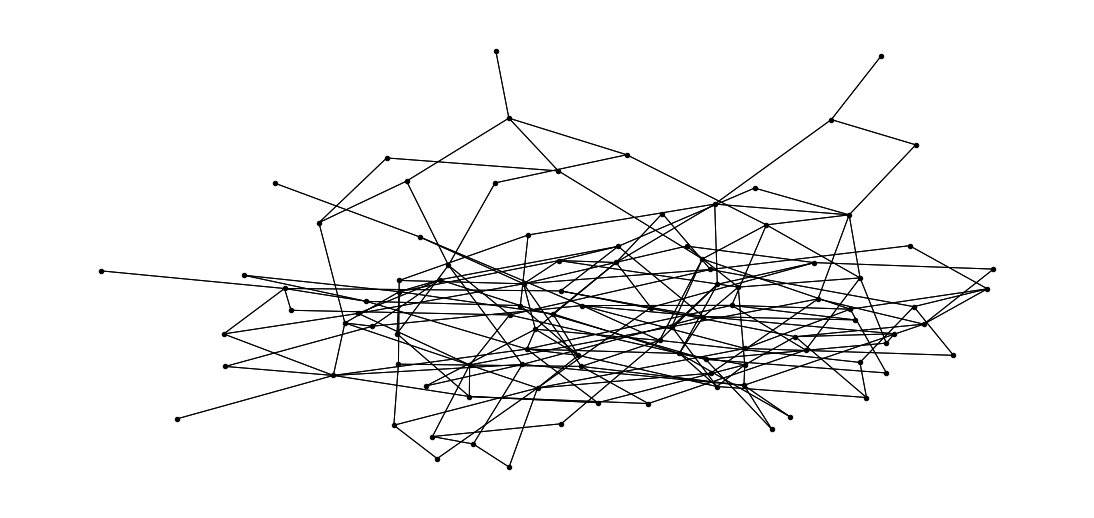

In [26]:

options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}
#G = dgl.to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw(Gra[0], **options)


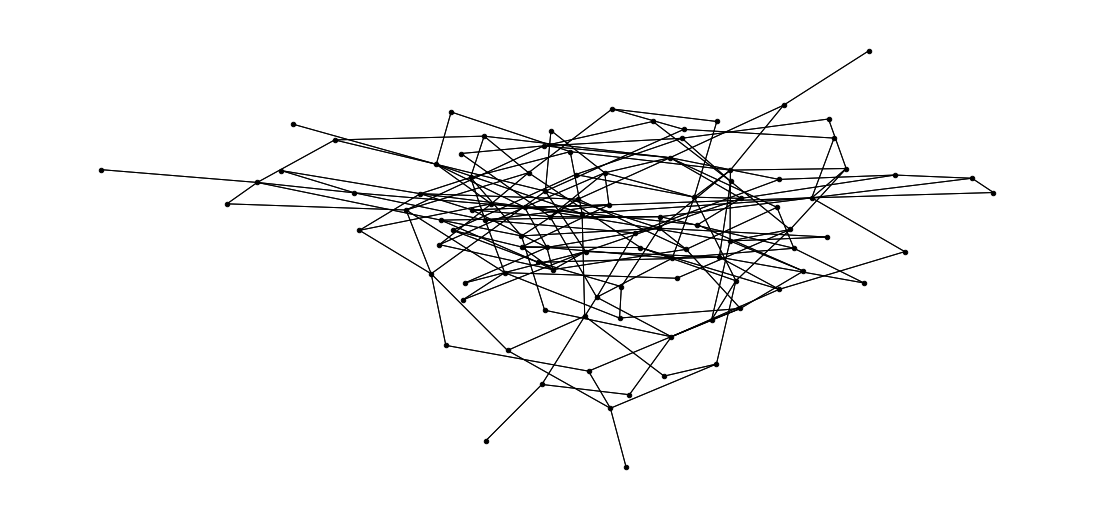

In [28]:

import networkx as nx

import matplotlib.pyplot as plt


options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}
#G = dgl.to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw(Gra[1], **options)

In [53]:
A = nx.adjacency_matrix(Gra[0])
B = nx.adjacency_matrix(Gra[50])

In [43]:
G[0][0] == G[0][1]

False

In [55]:
y = B.todense()
x = A.todense()

In [56]:
x == y

matrix([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])